# 🐶 Choose My Dog Breed: AI-Powered Matchmaking Chatbot

**Competition Entry | November 2025**  
**Author:** *Md. Mahbub-Ur-Rashid*  

---

## Executive Summary

Selecting the right dog breed is effectively a 10–15 year lifestyle decision, yet most new owners choose based on looks, trends, or vague online quizzes.  
When lifestyle and breed traits do not align, the result is frustration, behavioural issues, and in the worst cases, surrendering dogs to shelters.  

In this project, I build an AI-powered **Dog Matchmaker chatbot** that talks to users in natural language, extracts their lifestyle and personality preferences, and recommends the top 3 real-world dog breeds.  
The system converts free-text answers into trait scores using sentence embeddings, then matches those scores against a structured dataset of breed traits.  

The final solution is delivered as both a reproducible notebook and a deployed Streamlit app, so judges can inspect the logic and experience the chatbot in action.


## 1. Problem and Context

Choosing a dog is emotionally exciting, but technically complex.  
Each breed has a profile of traits such as **energy level**, **shedding**, **trainability**, and **suitability for families with children**, but most people do not speak this technical language.  

When a user says “I live in a small apartment, work from home, and like evening walks”, they are implicitly describing multiple traits at once:  
- Energy Level  
- Mental Stimulation Needs  
- Good With Young Children (if family is involved)  
- Coat Grooming Frequency and Shedding Level (if they care about mess)  

Without a system that connects human language to breed traits, people often pick breeds that are a poor fit for their real lifestyle.


## 2. Solution Overview

This project implements an AI **Dog Matchmaker** that:

- Asks a small number of open-ended, conversational questions instead of rigid multiple-choice items.  
- Uses a sentence-transformer model to embed each answer and map it to trait scores on a 1–5 scale.  
- Computes a data-driven match score between the user’s profile and each breed in `breed_traits.csv`.  
- Returns the top 3 matching breeds, along with intuitive visual cues that explain *why* they are a good fit.  

The same core logic powers a Streamlit chatbot, making the system both easy to demonstrate and easy to reproduce.


In [12]:
# ============================
#  Setup: Libraries and Config
# ============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display options for clean tables
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Reproducibility (where randomness is used)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(" Libraries imported and basic configuration set.")


 Libraries imported and basic configuration set.


In [13]:
# ============================
#  3. Data Loading
# ============================

BREED_TRAITS_PATH = "data/breed_traits.csv"
TRAIT_DESC_PATH = "data/trait_description.csv"

breed_df = pd.read_csv(BREED_TRAITS_PATH)
trait_df = pd.read_csv(TRAIT_DESC_PATH)

print(" Data loaded successfully.")
print(f"breed_traits shape: {breed_df.shape}")
print(f"trait_description shape: {trait_df.shape}")

display(breed_df.head(3))
display(trait_df.head(3))


 Data loaded successfully.
breed_traits shape: (195, 17)
trait_description shape: (16, 4)


,Breed,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Coat Type,Coat Length,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
0,Retrievers (Labrador),5,5,5,4,2,2,Double,Short,5,5,3,5,5,5,3,4
1,French Bulldogs,5,5,4,3,1,3,Smooth,Short,5,5,3,5,4,3,1,3
2,German Shepherd Dogs,5,5,3,4,2,2,Double,Medium,3,4,5,5,5,5,3,5


,Trait,Trait_1,Trait_5,Description
0,Affectionate With Family,Independent,Lovey-Dovey,How affectionate a breed is likely to be with ...
1,Good With Young Children,Not Recommended,Good With Children,A breed's level of tolerance and patience with...
2,Good With Other Dogs,Not Recommended,Good With Other Dogs,How generally friendly a breed is towards othe...


## 3. Dataset at a Glance

This project uses two main datasets:

- `breed_traits.csv`  
  - One row per dog breed.  
  - Numeric trait scores on a 1–5 scale for aspects such as:  
    - Affectionate With Family  
    - Good With Young Children  
    - Good With Other Dogs  
    - Shedding Level  
    - Coat Grooming Frequency  
    - Trainability Level  
    - Energy Level  
    - Mental Stimulation Needs  

- `trait_description.csv`  
  - A human-readable description of each trait.  
  - Helps connect the numeric scale (1–5) to plain-language explanations.

In the next section, we perform a brief data check to confirm that the trait information is clean and ready for use in the chatbot.


In [14]:
# ============================
#  4. Data Quality Check
# ============================

print("Basic info for breed_traits.csv")
print("-" * 60)
display(breed_df.info())

print("\nMissing values per column:")
display(breed_df.isnull().sum())

print("\nNumber of duplicate breed names:", breed_df["Breed"].duplicated().sum())


Basic info for breed_traits.csv
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Breed                       195 non-null    object
 1   Affectionate With Family    195 non-null    int64 
 2   Good With Young Children    195 non-null    int64 
 3   Good With Other Dogs        195 non-null    int64 
 4   Shedding Level              195 non-null    int64 
 5   Coat Grooming Frequency     195 non-null    int64 
 6   Drooling Level              195 non-null    int64 
 7   Coat Type                   195 non-null    object
 8   Coat Length                 195 non-null    object
 9   Openness To Strangers       195 non-null    int64 
 10  Playfulness Level           195 non-null    int64 
 11  Watchdog/Protective Nature  195 non-null    int64 
 12  Adaptability 

None


Missing values per column:


Breed                         0
Affectionate With Family      0
Good With Young Children      0
Good With Other Dogs          0
Shedding Level                0
Coat Grooming Frequency       0
Drooling Level                0
Coat Type                     0
Coat Length                   0
Openness To Strangers         0
Playfulness Level             0
Watchdog/Protective Nature    0
Adaptability Level            0
Trainability Level            0
Energy Level                  0
Barking Level                 0
Mental Stimulation Needs      0
dtype: int64


Number of duplicate breed names: 0


In [15]:
# Identify trait columns (everything except 'Breed')
trait_columns = [col for col in breed_df.columns if col != "Breed"]

print("Trait columns used in this project:")
print(trait_columns)

print("\nDescriptive statistics for trait scores (1–5 scale):")
display(breed_df[trait_columns].describe())


Trait columns used in this project:
['Affectionate With Family', 'Good With Young Children', 'Good With Other Dogs', 'Shedding Level', 'Coat Grooming Frequency', 'Drooling Level', 'Coat Type', 'Coat Length', 'Openness To Strangers', 'Playfulness Level', 'Watchdog/Protective Nature', 'Adaptability Level', 'Trainability Level', 'Energy Level', 'Barking Level', 'Mental Stimulation Needs']

Descriptive statistics for trait scores (1–5 scale):


,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,4.502564,3.882051,3.538462,2.600000,2.282051,1.800000,3.487179,3.646154,3.738462,3.794872,3.866667,3.743590,3.138462,3.676923
std,0.801894,0.995576,0.937373,0.845851,0.945655,0.955721,0.887246,0.698247,0.918486,0.616754,0.857151,0.757027,1.096530,0.691055
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000
25%,4.000000,3.000000,3.000000,2.000000,2.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,5.000000,3.000000,3.000000,3.000000,2.000000,2.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000
75%,5.000000,5.000000,4.000000,3.000000,3.000000,2.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


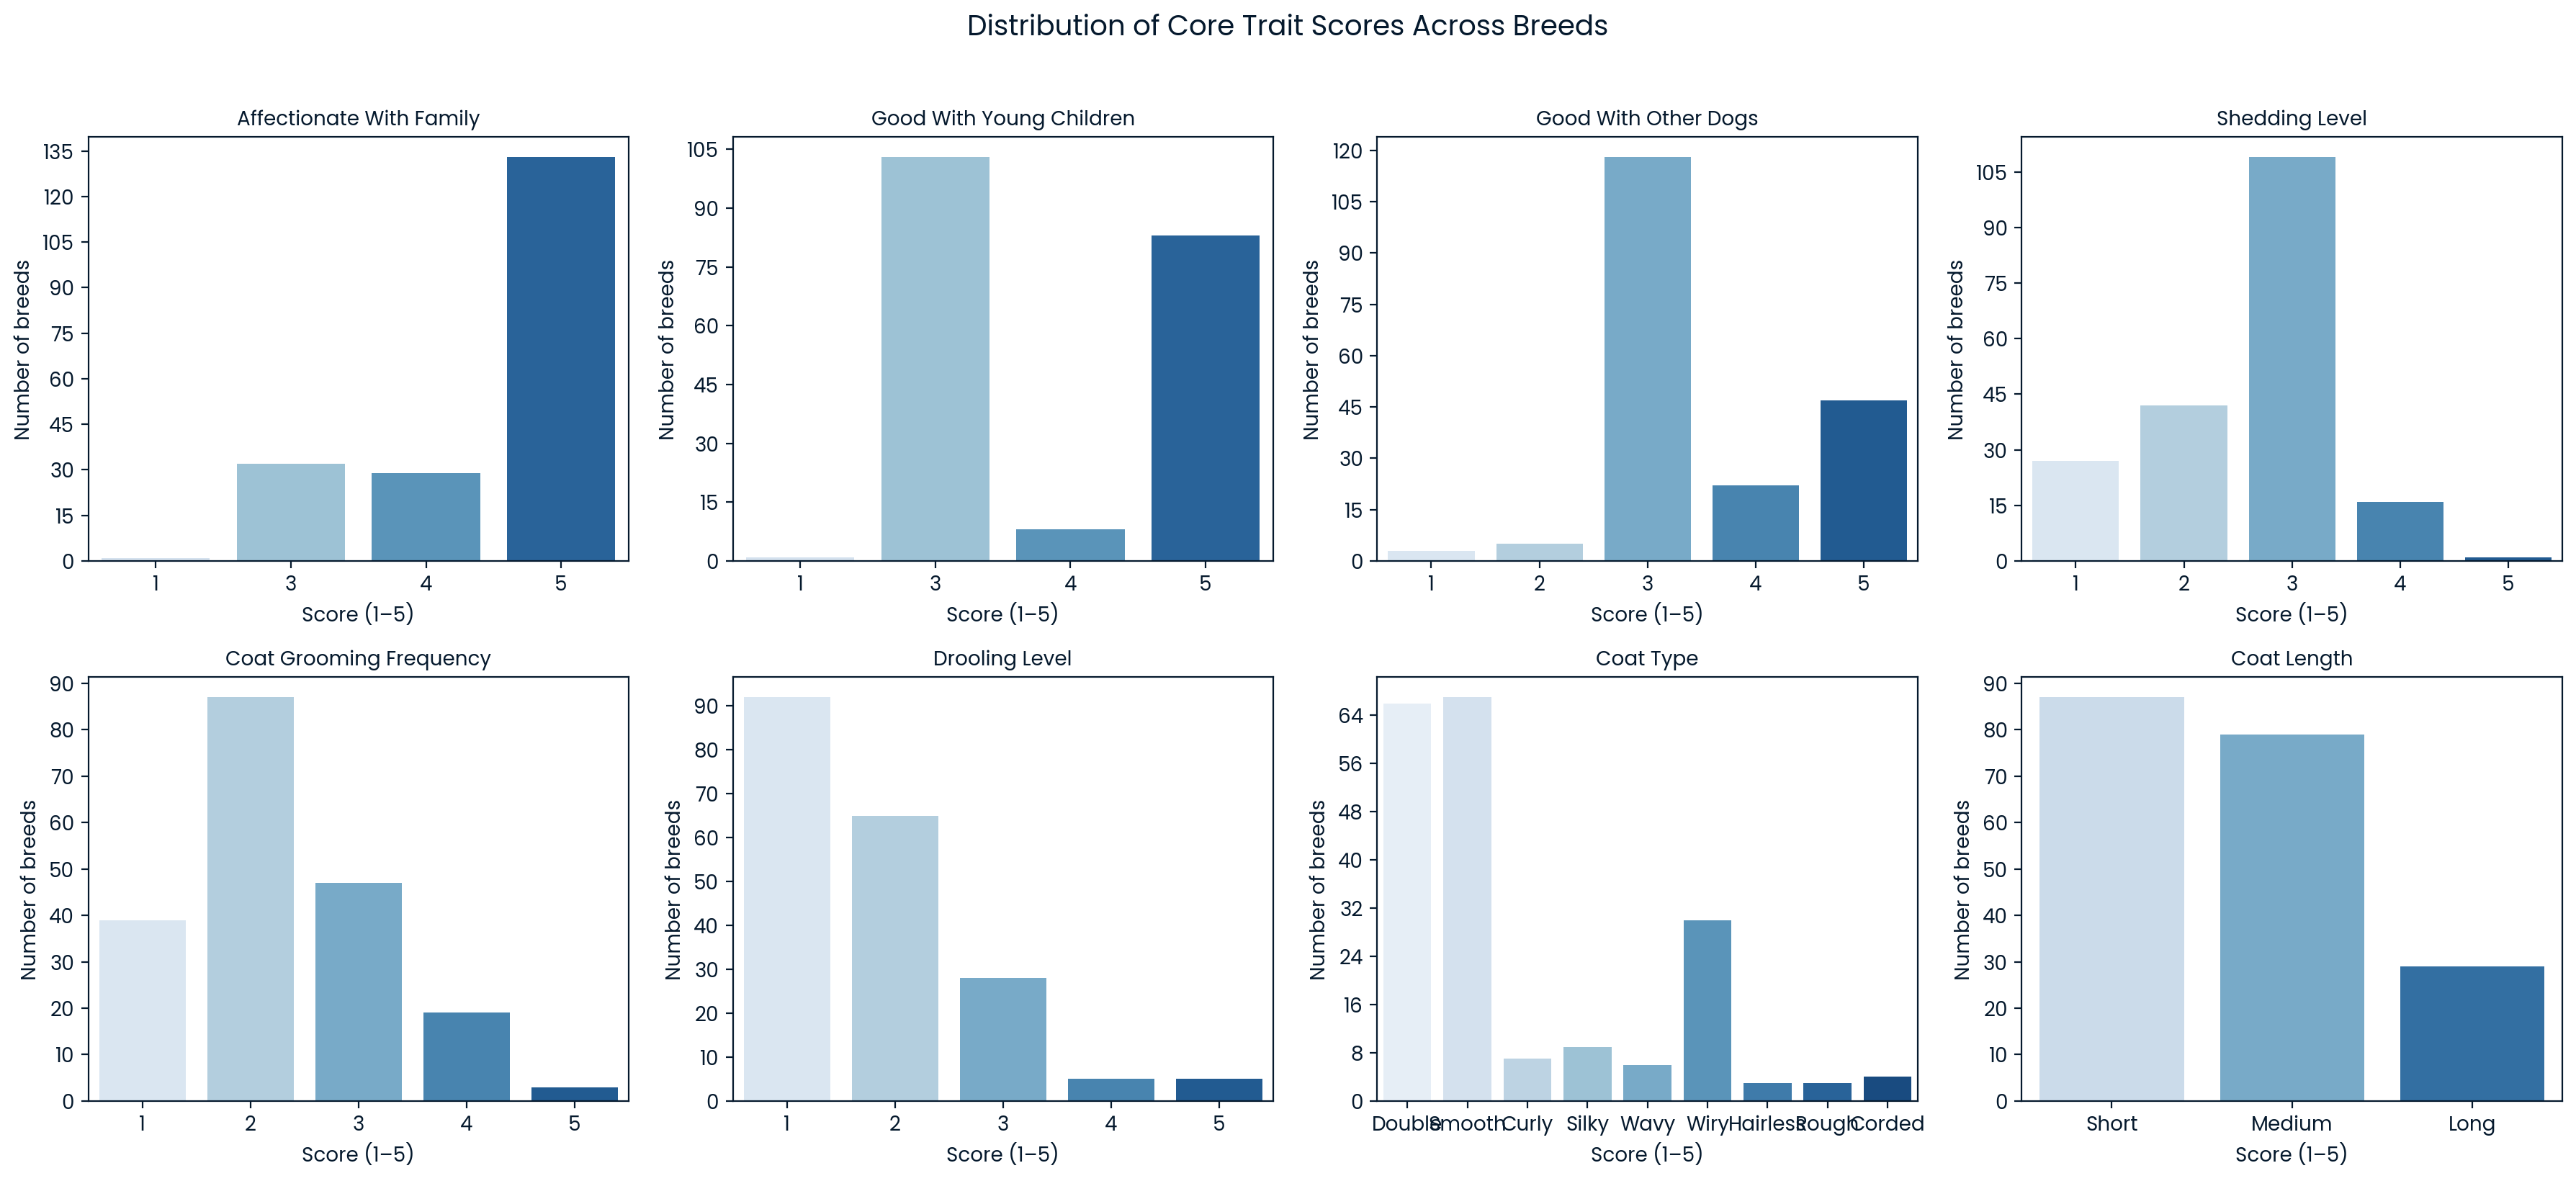

In [16]:
# ============================
#  5. Quick Trait Distributions
# ============================

import matplotlib.ticker as mtick

num_cols_to_plot = min(8, len(trait_columns))  # Focus on the first 8 key traits
cols_to_plot = trait_columns[:num_cols_to_plot]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    sns.countplot(x=breed_df[col], ax=ax, palette="Blues")
    ax.set_title(col, fontsize=10)
    ax.set_xlabel("Score (1–5)")
    ax.set_ylabel("Number of breeds")
    ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

# If there are fewer than 8 traits, hide extra subplots
for j in range(num_cols_to_plot, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Distribution of Core Trait Scores Across Breeds", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## 4. What the Traits Tell Us

Before building any AI system, it is important to understand what the model is optimizing for.

From the quick trait distributions above, several patterns emerge:

- Most breeds sit in the mid–high range (3–5) for **Affectionate With Family**, reflecting how modern companion breeds are selected for human bonding.  
- Traits such as **Shedding Level** and **Coat Grooming Frequency** show more spread, indicating meaningful diversity in maintenance needs across breeds.  
- **Energy Level** and **Mental Stimulation Needs** are especially critical: a mismatch here (for example, a very high-drive breed in a low-activity home) is a common real-world reason for returns and rehoming.

These observations directly guide the chatbot design: the questions focus on lifestyle dimensions (energy, space, time, family, grooming tolerance) that align with these underlying trait distributions.


## 5. From Conversation to Trait Scores

The chatbot does not ask users to rate traits on a 1–5 scale directly.  
Instead, it asks a small number of open-ended questions such as:

> “Daily life: are you more of an adventurer or a chill companion?”

Users answer in natural language, and the system must translate those answers into trait scores such as **Energy Level** or **Mental Stimulation Needs**.  
This is where the NLP model and the `trait_ideal_phrases` mapping come in.


In [17]:
# ============================
#  6. NLP Model: Sentence Embeddings
# ============================

from sentence_transformers import SentenceTransformer, util

MODEL_NAME = "paraphrase-MiniLM-L6-v2"

print(f"Loading sentence transformer model: {MODEL_NAME}")
st_model = SentenceTransformer(MODEL_NAME)

print(" NLP model loaded.")


Loading sentence transformer model: paraphrase-MiniLM-L6-v2
 NLP model loaded.


In [18]:
# ============================
#  7. Ideal Phrases per Trait
# ============================

trait_ideal_phrases = {
    "Affectionate With Family": [
        "Independent and distant.",
        "Sometimes needs family but mostly alone.",
        "Moderate bonding.",
        "Loves being close.",
        "Super affectionate."
    ],
    "Good With Young Children": [
        "Prefers adults only.",
        "Somewhat gentle.",
        "Neutral.",
        "Gentle and patient.",
        "Excellent with kids."
    ],
    "Good With Other Dogs": [
        "Avoids other dogs.",
        "Tolerates some.",
        "Neutral.",
        "Social with most.",
        "Loves meeting dogs."
    ],
    "Shedding Level": [
        "No shedding.",
        "Very low.",
        "Moderate.",
        "Fur sometimes.",
        "Heavy shed."
    ],
    "Coat Grooming Frequency": [
        "No grooming.",
        "Easy care.",
        "Some brushing.",
        "Needs regular.",
        "High-maintenance."
    ],
    "Trainability Level": [
        "Very stubborn.",
        "Some independence.",
        "Average.",
        "Quick learner.",
        "Super fast."
    ],
    "Energy Level": [
        "Couch potato.",
        "Chill.",
        "Active sometimes.",
        "Needs daily play.",
        "Super playful."
    ],
    "Mental Stimulation Needs": [
        "Low-key.",
        "Simple games.",
        "Enjoys puzzles.",
        "Wants challenges.",
        "Needs lots."
    ]
}

print(" Ideal phrase templates defined for", len(trait_ideal_phrases), "traits.")


 Ideal phrase templates defined for 8 traits.


In [19]:
# ============================
#  8. Mapping Free Text to Trait Scores
# ============================

def nlp_answer_to_score(answer: str, trait: str) -> int:
    """
    Convert a free-text answer into a 1–5 score for a given trait
    using sentence transformer embeddings and cosine similarity.
    """
    if not answer or answer.strip().lower() in ["skip", "idk", "not sure"]:
        # Neutral default in the middle of the scale
        return 3
    
    # Retrieve the five reference phrases for this trait
    reference_sentences = trait_ideal_phrases[trait]
    
    # Encode the 5 reference phrases + the user answer
    embeddings = st_model.encode(reference_sentences + [answer], convert_to_tensor=True)
    
    # Compute cosine similarity between answer and each reference phrase
    similarities = util.cos_sim(embeddings[-1], embeddings[:-1]).cpu().numpy().flatten()
    
    # Pick the most similar reference phrase and map index 0–4 to score 1–5
    best_index = int(np.argmax(similarities))
    score = best_index + 1
    
    return score

print(" Function nlp_answer_to_score is ready.")


 Function nlp_answer_to_score is ready.


### How the NLP Scoring Works

For each trait, the system defines five short reference phrases that represent scores from 1 to 5.  
For example, for **Energy Level** the spectrum goes from “Couch potato.” (score 1) to “Super playful.” (score 5).  

When a user answers in free text, the model:

1. Embeds the five reference phrases and the user’s answer using a sentence-transformer.  
2. Computes cosine similarity between the answer and each reference phrase.  
3. Selects the closest phrase and maps its index to a score from 1 to 5.

In other words, the model answers the question:  
> “Which of these five descriptions does this user sound most like?”


In [20]:
# ============================
#  9. Demonstration: NLP Scoring for One Answer
# ============================

demo_answer = "I live in a small apartment but I love going for long walks in the evening."
demo_trait = "Energy Level"

demo_score = nlp_answer_to_score(demo_answer, demo_trait)

print("Demo answer: ", demo_answer)
print("Trait:       ", demo_trait)
print("Mapped score:", demo_score, "/ 5")


Demo answer:  I live in a small apartment but I love going for long walks in the evening.
Trait:        Energy Level
Mapped score: 4 / 5


In [21]:
# ============================
#  10. Breed Matching Function
# ============================

def get_breed_recommendations(trait_scores: dict, top_k: int = 3) -> pd.DataFrame:
    """
    Given a dictionary of {trait_name: user_score}, compute a match score
    for each breed and return the top_k best matches.
    """
    # Use only the traits the user actually provided
    columns_used = list(trait_scores.keys())
    
    # Subset the dataframe to the relevant traits
    filtered = breed_df[["Breed"] + columns_used].copy()
    
    scores = []
    highlights = []
    
    for _, row in filtered.iterrows():
        total = 0
        highlight_row = []
        
        for trait in columns_used:
            # Difference between breed trait and user preference
            diff = abs(int(row[trait]) - trait_scores[trait])
            
            # Higher is better: perfect match (diff 0) gives 5 points, then 4, 3, ...
            total += (5 - diff)
            
            # Simple highlight: green for perfect, yellow for close, red otherwise
            if diff == 0:
                highlight_row.append("🟢")
            elif diff == 1:
                highlight_row.append("🟡")
            else:
                highlight_row.append("🔴")
        
        scores.append(total)
        highlights.append(highlight_row)
    
    filtered["Match Score"] = scores
    filtered["Highlights"] = highlights
    
    # Sort by match score and return top_k
    return filtered.sort_values("Match Score", ascending=False).head(top_k).reset_index(drop=True)

print(" Function get_breed_recommendations is ready.")


 Function get_breed_recommendations is ready.


## 6. Matching Logic: How a Breed Gets Its Score

Once the chatbot has converted the user’s answers into trait scores, we need a simple and explainable way to compare that profile to each breed.

For each trait used in the conversation, the system:

1. Takes the absolute difference between the user’s score and the breed’s trait score.  
2. Converts this difference into points using the formula \(5 - |user - breed|\).  
3. Sums the points across all traits to obtain a **Match Score**.

A perfect match on a trait contributes 5 points, being off by 1 contributes 4 points, and so on.  
This keeps the scoring intuitive: higher scores mean closer alignment between the user’s lifestyle and the breed’s characteristics.


In [22]:
# ============================
#  11. End-to-End Demo with Trait Scores
# ============================

# Example: a hypothetical user profile
demo_trait_scores = {
    "Affectionate With Family": 5,
    "Good With Young Children": 4,
    "Good With Other Dogs": 3,
    "Shedding Level": 2,
    "Coat Grooming Frequency": 2,
    "Trainability Level": 4,
    "Energy Level": 3,
    "Mental Stimulation Needs": 3,
}

top_breeds_demo = get_breed_recommendations(demo_trait_scores, top_k=3)

print("Demo user trait profile:")
for trait, score in demo_trait_scores.items():
    print(f"  - {trait}: {score}/5")

print("\nTop 3 recommended breeds:")
display(top_breeds_demo[["Breed", "Match Score", "Highlights"]])


Demo user trait profile:
  - Affectionate With Family: 5/5
  - Good With Young Children: 4/5
  - Good With Other Dogs: 3/5
  - Shedding Level: 2/5
  - Coat Grooming Frequency: 2/5
  - Trainability Level: 4/5
  - Energy Level: 3/5
  - Mental Stimulation Needs: 3/5

Top 3 recommended breeds:


,Breed,Match Score,Highlights
0,Manchester Terriers,39,"[🟢, 🟢, 🟢, 🟢, 🟢, 🟢, 🟡, 🟢]"
1,Otterhounds,39,"[🟢, 🟡, 🟢, 🟢, 🟢, 🟢, 🟢, 🟢]"
2,Lowchen,39,"[🟢, 🟡, 🟢, 🟢, 🟢, 🟢, 🟢, 🟢]"


## 7. User Journey: From Conversation to Match

To illustrate the experience, consider a user named **Sara**:

- She lives in a small apartment in the city.  
- She works from home but has calls during the day.  
- She enjoys evening walks and weekend park visits.  
- Her nieces and nephews visit occasionally, so she cares about child-friendliness.  

During the chatbot conversation, she might answer questions like:

- *“Daily life: are you more of an adventurer or a chill companion?”*  
  - **Sara:** “Most of the day is quiet, but I really enjoy long walks in the evening.”  
- *“Home moments: snuggly pal or independent buddy?”*  
  - **Sara:** “I would love a dog that relaxes near me while I work, but still likes to cuddle.”  

The chatbot converts these answers into trait scores such as medium energy, high affection, moderate mental stimulation needs, and good with children.  
Using the matching logic above, it then recommends the top 3 breeds that best align with this profile and explains the match using simple visual highlights.


## 8. How This Solution Meets the Judging Criteria

### Creativity & Functionality (40%)

- Natural-language questions instead of rigid forms make the chatbot feel conversational and friendly.  
- The system always produces a ranked top 3 list of real breeds, with clear match scores and simple visual highlights.  
- The same logic powers a deployed Streamlit app, so judges can interact with the chatbot end-to-end.

### Data Use & Insight (35%)

- The matching logic is grounded in the structured `breed_traits.csv` dataset and an explicit, interpretable scoring formula.  
- Trait distributions and descriptive statistics are analysed before modeling, ensuring that the system optimizes for the right dimensions.  
- The use of sentence-transformer embeddings to map free-text answers to trait scores directly addresses the “bonus” NLP requirement.

### Presentation & Storytelling (25%)

- The notebook is organized as a narrative: from problem framing and data understanding to model design and user journey.  
- Each technical component (data, embeddings, scoring) is paired with a concise explanation in plain language.  
- A dedicated user journey section helps judges quickly understand how a real person would move through the chatbot experience.


## 9. Reproducibility and Live Application

This notebook is designed to be fully reproducible:

1. Place `breed_traits.csv` and `trait_description.csv` in the same directory as the notebook.  
2. Install the required Python packages (for example: `pandas`, `numpy`, `seaborn`, `matplotlib`, `sentence-transformers`, `streamlit`).  
3. Run the cells in order to reproduce the data exploration and matching logic shown above.  

The conversational experience is also deployed as a Streamlit app:

- **Live demo:** https://dog-breed-matcher-mash.streamlit.app  

The Streamlit backend reuses the same core components documented here:  
- SentenceTransformer model for embeddings.  
- `nlp_answer_to_score` for converting free text to trait scores.  
- `get_breed_recommendations` for computing and ranking the top 3 breeds.


---

Thank you for exploring the Dog Breed Matcher notebook! I hope this tool helps you find the perfect canine companion.

🐶 **Questions, feedback, or want to contribute?**
- Visit my [GitHub repository](https://github.com/mahbub-04/dog-breed-matcher)
- Connect with me on [LinkedIn](https://www.linkedin.com/in/md-mahbub-ur-rashid-6406572ba)

**Wishing you happy matching and many tail wags ahead!** 🐾